# Laboratorio 1: Programación Lineal Mixta (MA4702, otoño 2023)

Profesor: Marcos Kiwi.<br/>
Auxiliares: Benjamín Jauregui y Cristián Palma.<br/>

## Preliminares

Este laboratorio consta de 3 etapas. Una tarea introductoria, una etapa presencial y otra no-presencial.
La nota global del laboratorio será 30 % (TI) + 40 % (TP) + 30 % (TNP), donde (TI) es la nota de la tarea
introductoria, (TP) la nota del trabajo presencial y (TNP) la nota del trabajo no presencial.

La tarea introductoria es de carácter estrictamente individual. La etapa presencial y no-presencial son de carácter grupal. 

## Laboratorio 1: Tarea Presencial (TP) y Tarea No-presencial (TNP)


# Instrucciones.

En la parte presencial del laboratorio, realice las siguientes actividades:

* Complete la celda “A. Datos grupo”.
* Descargue los archivos y funciones auxiliares de UCursos (todos deben quedar en el mismo directorio en que está almacenado este archivo).
* Complete la sección "B. preparación".
* Lea el enunciado y complete los ejercicios 1, 2 y 3.
* Envíe el archivo .ipynb por el módulo de tareas de UCursos en la TAREA: Laboratorio 1 presencial. 
* Plazo de entrega: **miércoles 29 de marzo a las 18:00** (se descontará 0.5 pts. por cada 15 min o fracción de atraso).

En la parte no presencial del laboratorio, realice las siguientes actividades:

* Complete todos los ejercicios
* Envíe el archivo .ipynb por el módulo de tareas de UCursos en la TAREA: Laboratorio 1 completo.
* Plazo de entrega: **viernes 31 de marzo a las 22:00** (se descontará 0.5 pts. por cada hora de atraso).



## A. Datos del grupo

<div class="alert alert-block alert-success">&nbsp;

- Número o identificador del Grupo: 9
    
- Integrante 1: Miguel Escobar

- Integrante 2: Nicolás Fuenzalida     </div>


## B. Preparación

Usaremos los paquetes JuMP, Gurobi, Distances, Plots, Graphs y Combinatorics.
A continuación, descomente las líneas pertinentes si no tiene instalados los respectivos paquetes y asegúrese de tener la última versión de JuMP corriendo (1.9.0 a marzo de 2023)

In [ ]:
import Pkg
#Pkg.add("Distances")        # Para instalar Distances
#Pkg.add("Plots")            # Para instalar Plots
#Pkg.add("Graphs")           # Para instalar Graphs
#Pkg.add("Combinatorics")    # Para instalar Combinatorics
#Pkg.update("JuMP")          # Para acutalizar JuMP
Pkg.status("JuMP")


In [1]:
using JuMP, Gurobi, Distances, Plots, Graphs, Combinatorics
const GUROBI_ENV = Gurobi.Env()      #Esta referencia  nos servirá para usar solo un ambiente de Gurobi.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22


Gurobi.Env(Ptr{Nothing} @0x000001d8421f1de0, false, 0)

* En este problema calcularemos árboles generadores de peso mínimo con restricciones en los grados que conectan puntos en el plano. 

Para cargar los archivos de entrada y visualizar información usaremos algunas funciones pre-escritas. El archivo "lab1-funciones.jl", descrito a continuación, tiene las funciones que necesitaremos.

```julia
dibuja(coordx,coordy,arcos)
# Recibe dos arreglos de N valores donde (coordx[i],coordy[i]) son las coordenadas del punto i.
# Recibe además una matriz arcos de N x N, donde arcos[i,j] es el peso del arco [i,j]
# Dibuja los N puntos en el plano y dibuja los arcos con ancho de linea proporcional al peso.

lee_archivo(nombre_archivo)
# Recibe un archivo con las coordenadas de N puntos, devolviendo N, las coordenadas x, las coordenadas y, 
# y un vector de restricción de grado b.

componente_conexa(A)
# Recibe una matriz de adyacencia A de un digrafo G, ignora la orientación de los arcos y retorna un 
# arreglo cuyos elementos son arreglos de enteros (tantos elementos como componentes conexas tenga el 
# digrafo G). Cada uno de los arreglos de enteros corresponde a los índices de los vértices de una 
# componente conexa de G.
```

* Cargue el archivo empleando el siguiente comando:

In [3]:
include("lab1-funcionalidad.jl");

* Pruebe las funciones auxiliares cargando el archivo "lab1-ejemplo3.txt" (con 25 puntos), y dándole peso a algunas aristas como sigue:

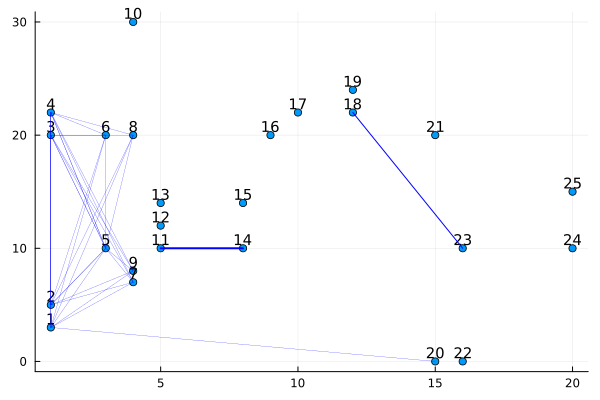

In [12]:
N,x_pos,y_pos=lee_archivo("lab1-ejemplo4.txt")
aristas_ejemplo=zeros(N,N)
aristas_ejemplo[11,14]=1
aristas_ejemplo[1,20]=0.1
aristas_ejemplo[18,23]=0.5
for i in 1:5
    for j in 2:9
        aristas_ejemplo[i, j ] = 0.1

    end
end

dibuja(x_pos,y_pos,aristas_ejemplo)

In [14]:
length(y_pos)



25

* Pruebe como generar todos los subconjuntos propios de [1 2 3] usando la función ```powerset()``` del paquete Combinatorics.

In [18]:
N = 4
for S in powerset(1:N)
    println(typeof(S))

end



Vector

{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}
Vector{Int64}


## Formulación como PLE

Las instancias del problema del árbol generador de peso mínimo con restricción en los grados están determinadas por una función $c:E\to\mathbb{R}_+$ donde $c(e)$ representa la distancia (o peso) del arco $e$ de $G$. Este problema es NP-completo y difícil de abordar en toda generalidad.

Sin pérdida de generalidad, podemos asumir que $G$ es grafo completo (extendiendo $c(\cdot)$ asignándole un peso muy grande a los “arcos” que no están en $G$). Como se adelantó en la parte previa al laboratorio, el problema que nos interesa estudiar se puede formular como un programa entero. Concretamente, sea $G=(V,E)$ un grafo completo (no dirigido y sin bucles).  Denotamos por $b_v\in\mathbb{N}$ la cota superior en el grado del vértice $v\in V$ en el árbol generador. Consideremos el siguiente programa lineal binario:

$$
\begin{array}{rlllr}
& \min_{z} \sum_{e\in E}c_{e}z_{e} \\
s.a. & \\
& \sum_{e\in E} z_{e} = |V|-1, \\
& \sum_{e\in \delta(S)} z_{e} \geq 1, & \forall\emptyset\subsetneq S\subsetneq V,
& \text{(restricción de cortes)}\\
& 1 \leq \sum_{e=\{u,w\}\in E:v\in\{u,w\}} z_{e} \leq b_v, & \forall v\in V, \\
& z_e\in\{0,1\}, \forall e\in E. \\
\end{array}
$$

Una forma alternativa que se presta mejor para trabajar en Julia/JuMP/Gurobi consiste en definir $c_{u,v}=c(\{u,v\})$, trabajar con variables $z_{u,v}$ con $u,v\in V$ y usar la siguiente formulación equivalente:
$$
\begin{array}{rlllr}
(M_1): & \min_{z} \frac12\sum_{u,v\in V}c_{u,v}z_{u,v} \\
s.a. & \\
& z_{u,u} = 0, & \forall u\in V, \\
& z_{u,v} = z_{v,u}, & \forall u,v\in V, \\
& \sum_{u,v\in V} z_{u,v} = 2(|V|-1), \\
& \sum_{u,v\in V: u\in S, v\not\in S} z_{u,v} \geq 1, & \forall\emptyset\subsetneq S\subsetneq V,
& \text{(restricción de cortes)}\\
& 1 \leq \sum_{u\in V} z_{u,v} \leq b_v, & \forall v\in V, \\
& z_{u,v}\in\{0,1\}, \forall u,v\in V. \\
\end{array}
$$
**Nota:** Si bien hemos algo más que duplicado la cantidad de variables, las nuevas variables están ya sea fijas, o completamente determinadas por las variables antiguas. Los solvers manejan bien estas situaciones y no se ven mayormente impactados en su eficiencia. 

Como se puede apreciar, $(M_1)$ tiene una cantidad exponencial (en $|V|$) de restricciones. Inclusive la relajación de $(M_1)$, donde la condición $z_{u,v}\in\{0,1\}$ se reemplaza por $0\leq z_{u,v}\leq 1$ resulta,  en la práctica, imposible de resolver salvo para valores de $|V|$ pequeños.

## Ejercicio 1
Para comenzar, estudiemos como crece el tiempo requerido para la formulación y/o resolución de la relajación $(RM_1)$.  Esto además servirá para recordar como se escribe un PLM en JuMP y familiarizarse con funciones de Julia para medir tiempos de ejecución.

Complete la siguiente plantilla:

In [73]:
function resuelveM1(nombre_archivo)
## Resuelve M1, devuelve el valor y dibuja la solución
  
    #Cargar datos del archivo
    N,x_pos,y_pos,b = lee_archivo(nombre_archivo)
    
    #Crear un modelo nuevo. 
    #la variable GUROBI_ENV creada permite reutilizar el ambiente de Gurobi en vez de crear uno nuevo cada
    #vez que creamos un modelo (en particular, ya no saldrán múltiples mensajes sobre la licencia académica)
    M1 = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 1))

    #Crear variables, z es binaria.
    @variable(M1, z[1:N, 1:N], Bin)
    #Crear objetivo (usamos "euclidean" del paquete Distances para calcular la distancia euclideana)
    #Usar euclidean([x_pos[i],y_pos[i]],[x_pos[j],y_pos[j]] para calcular peso del arco entre el punto i y j.
    @objective(M1, Min, .5*sum(euclidean([x_pos[i], y_pos[i]], [x_pos[j], y_pos[j]])*z[i, j] for i in 1:N, j in 1:N))   #Crear restricciones
    @constraints(M1, begin
         [u ∈ 1:N], z[u, u] == 0
         [u ∈ 1:N, v ∈ 1:N], z[v, u] - z[u, v] == 0
         sum(z[u, v] for u in 1:N, v in 1:N) == 2*(N-1)
         [S ∈ powerset(1:N, 1, N-1)], sum([z[u, v] for u in S, v in 1:N if v ∉ S]) ≥ 1
         [v ∈ 1:N], 1 ≤ sum(z[u, v] for u in 1:N) ≤ b[v]
    end)
    
    #optimizar! (en un grafo completo el modelo es siempre factible si N>1, sum(b)=2*(N-1), y b >= 1)
    optimize!(M1)
    
    #dibuja y retorna
    valor =  objective_value(M1)
    dibuja(x_pos,y_pos,value.(z))
    return valor 
end

resuelveM1 (generic function with 1 method)

* Grafique los puntos descritos por el archivo de entrada “lab1-ejemplo1.txt” (12 puntos). 

**Nota:** En todas las instancias con que trabajaremos durante el laboratorio, la restricción en el grado máximo de cada nodo se ha fijado de la misma forma, específicamente igual a $3$.

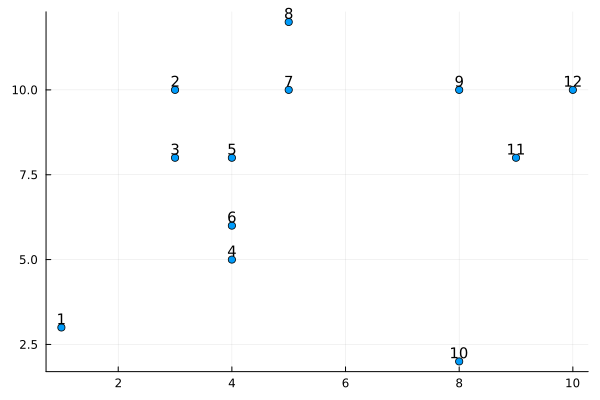

Any[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]12


In [45]:
N,x_pos,y_pos, b=lee_archivo("lab1-ejemplo1.txt")
dibuja(x_pos,y_pos,zeros(N,N))
println(b, N)


* Ahora resuelva y grafique las instancias descritas en los archivos "lab1-ejemplo1.txt", "lab1-ejemplo2.txt", "lab1-ejemplo3.txt" (si tiene problemas en la ejecución del último, coméntelo y no lo realice).

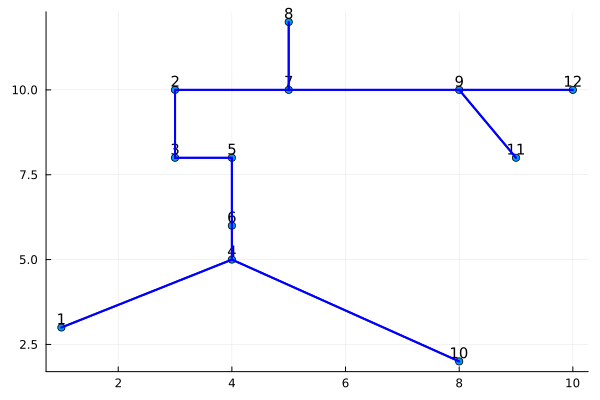

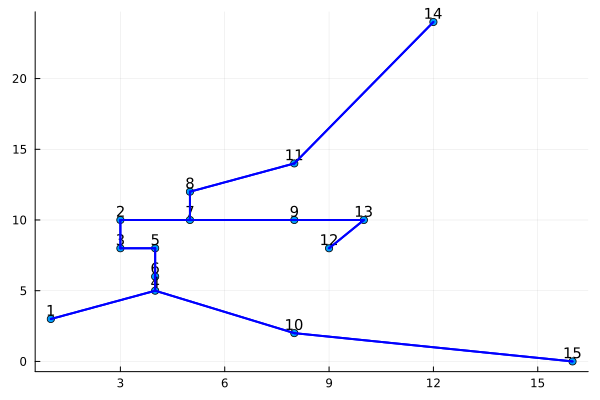

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8705G CPU @ 3.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4263 rows, 156 columns and 135744 nonzeros
Model fingerprint: 0x2ee66649
Variable types: 12 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 6e+00]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 64.3593608
Presolve removed 2215 rows and 78 columns
Presolve time: 0.11s
Presolved: 2048 rows, 78 columns, 67662 nonzeros
Variable types: 0 continuous, 78 integer (66 binary)

Root relaxation: objective 2.584162e+01, 8 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0      

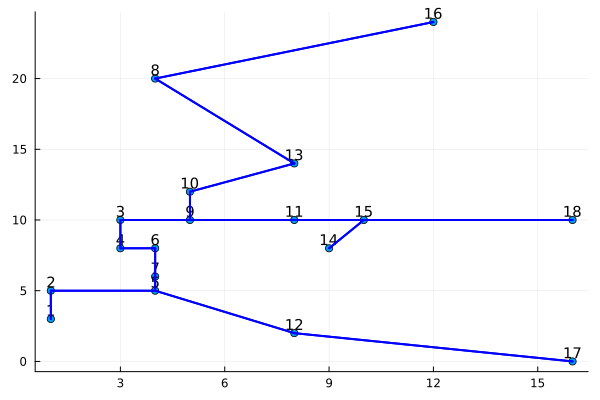


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8705G CPU @ 3.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 33022 rows, 240 columns and 1721220 nonzeros
Model fingerprint: 0xab5f8f8e
Variable types: 15 continuous, 225 integer (225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 136.4876412
Presolve removed 16638 rows and 120 columns
Presolve time: 2.73s
Presolved: 16384 rows, 120 columns, 860280 nonzeros
Variable types: 0 continuous, 120 integer (105 binary)
Root relaxation presolved: 16384 rows, 120 columns, 860280 nonzeros


Root relaxation: objective 4.770701e+01, 11 iterations, 0.45 seconds (0.46 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8705G CPU @ 3.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 262503 rows, 342 columns and 20055312 nonzeros
Model fingerprint: 0x64e8ee0f
Variable types: 18 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 142.7958469
Presolve removed 342 rows and 171 columns (presolve time = 7s) ...
Presolve removed 342 rows and 171 columns (presolve time = 12s) ...
Presolve removed 131431 rows and 171 columns (presolve time = 19s) ...
Presolve removed 131431 rows and 171 columns (presolve time = 21s) ...
Presolve removed 131431 rows and 171 columns (presolve time = 26s) ...
Presolve removed 131431 rows and 171 columns (presolve time = 30s) .

61.24320496512623

In [74]:
@time resuelveM1("lab1-ejemplo1.txt")
@time resuelveM1("lab1-ejemplo2.txt")
@time resuelveM1("lab1-ejemplo3.txt")

In [ ]:
Repita la ejecución, pero ahora midiendo la memoria utilizada (observe lo rápido que aumenta).

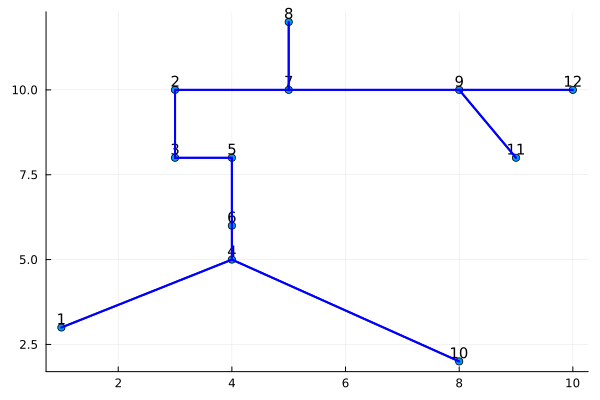

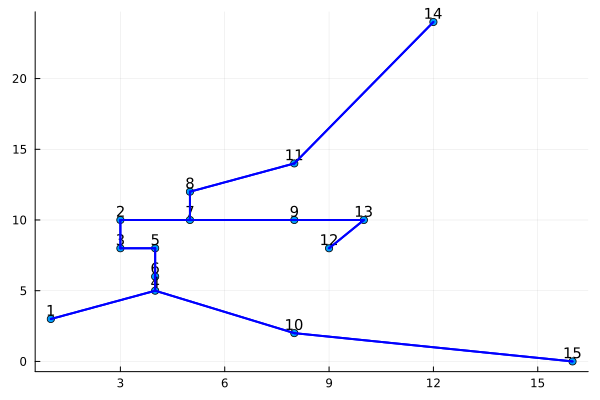

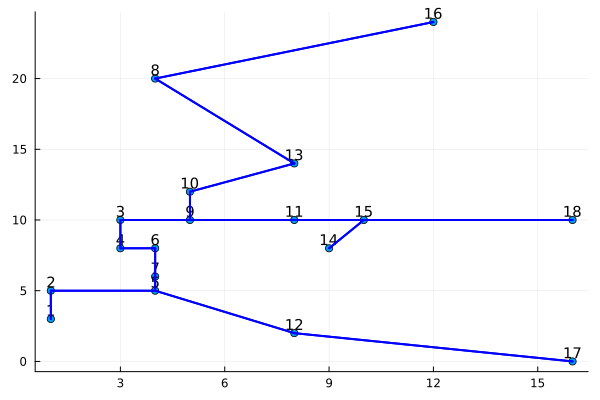

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8705G CPU @ 3.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4263 rows, 156 columns and 135744 nonzeros
Model fingerprint: 0x2ee66649
Variable types: 12 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 6e+00]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 64.3593608
Presolve removed 2215 rows and 78 columns
Presolve time: 0.09s
Presolved: 2048 rows, 78 columns, 67662 nonzeros
Variable types: 0 continuous, 78 integer (66 binary)

Root relaxation: objective 2.584162e+01, 8 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0      

In [75]:
m1 = @allocated resuelveM1("lab1-ejemplo1.txt");
m2 = @allocated resuelveM1("lab1-ejemplo2.txt");
m3 = @allocated resuelveM1("lab1-ejemplo3.txt");
println( "Bytes allocated: ", m1, " ", m2, " ", m3)

## Resolución iterativa mediante generación de filas (planos cortantes).

Para resolver $(M_1)$, intentaremos la siguiente estrategia:

1. Crear un modelo con variables **integrales** sin restricción de corte y resolverlo.
   Notar que si $z$ es el vector solución, entonces $z$ es una indicatriz de un subconjunto de arcos de $G$, por lo que define un subgrafo $G_z$ de $G$.  
2. Mientras $G_z$ no sea un árbol, determinamos una de sus componentes conexas y definimos $S=V(G_z)$. Notar que la restricción $z(\delta(S))\geq 1$ es violada. **La agregamos al modelo y volvemos a resolver**
3. Cuando $G_z$ es un árbol, $z$ es solución óptima.

## Ejercicio 2

Cree el modelo PC (por "Planos Cortantes") en Gurobi **sin incluir las restricciones de corte** completando la siguiente celda. Luego, resuélva el modelo y dibuje la salida usando la función dibujar. 

In [77]:
#Cargar los datos de la instancia descrita en el archivo "lab1-ejemplo3.txt" (25 puntos).
N,x_pos,y_pos,b=lee_archivo("lab1-ejemplo3.txt")

#Modelo PC
PC = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)); #sin salida esta vez

#Crear modelo PC

@variable(PC, z[1:N, 1:N], Bin)
#Crear objetivo (usamos "euclidean" del paquete Distances para calcular la distancia euclideana)
#Usar euclidean([x_pos[i],y_pos[i]],[x_pos[j],y_pos[j]] para calcular peso del arco entre el punto i y j.
@objective(PC, Min, .5*sum(euclidean([x_pos[i], y_pos[i]], [x_pos[j], y_pos[j]])*z[i, j] for i in 1:N, j in 1:N))   #Crear restricciones
@constraints(PC, begin
     [u ∈ 1:N], z[u, u] == 0
     [u ∈ 1:N, v ∈ 1:N], z[v, u] - z[u, v] == 0
     sum(z[u, v] for u in 1:N, v in 1:N) == 2*(N-1)
#     [S ∈ powerset(1:N, 1, N-1)], sum([z[u, v] for u in S, v in 1:N if v ∉ S]) ≥ 1
     [v ∈ 1:N], 1 ≤ sum(z[u, v] for u in 1:N) ≤ b[v]
end)

(ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}[z[1,1] == 0.0, z[2,2] == 0.0, z[3,3] == 0.0, z[4,4] == 0.0, z[5,5] == 0.0, z[6,6] == 0.0, z[7,7] == 0.0, z[8,8] == 0.0, z[9,9] == 0.0, z[10,10] == 0.0, z[11,11] == 0.0, z[12,12] == 0.0, z[13,13] == 0.0, z[14,14] == 0.0, z[15,15] == 0.0, z[16,16] == 0.0, z[17,17] == 0.0, z[18,18] == 0.0], ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}[0 == 0.0 z[2,1] - z[1,2] == 0.0 … z[17,1] - z[1,17] == 0.0 z[18,1] - z[1,18] == 0.0; -z[2,1] + z[1,2] == 0.0 0 == 0.0 … z[17,2] - z[2,17] == 0.0 z[18,2] - z[2,18] == 0.0; … ; -z[17,1] + z[1,17] == 0.0 -z[17,2] + z[2,17] == 0.0 … 0 == 0.0 z[18,17] - z[17,18] == 0.0; -z[18,1] + z[1,18] == 0.0 -z[18,2] + z[2,18] == 0.0 … -z[18,17] + z[17,18] == 0.0 0 == 0.0], z[1,1] + z[2,1] + z[3,1] + z[4,1] + z[5,1] + z[6,

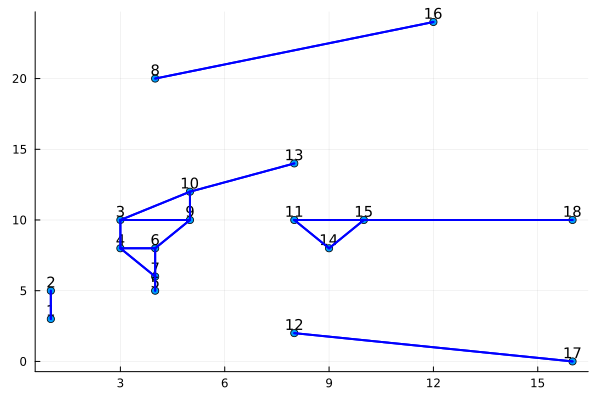

In [78]:
#Optimice PC y dibuje el resultado obtenido.
optimize!(PC)
dibuja(x_pos,y_pos,value.(z))

La función ```componente_conexa()``` (del archivo “lab1-funcionalidad.jl”) determina una componente conexa que contiene al primer punto de la instancia de entrada. Úsela para encontrar una componente conexa de $G_z$. Luego, si la componente no es igual a $V$, agregue a PC la restricción asociada al corte encontrado. Optimice y dibuje su nueva solución.

In [79]:
# Ejecutar función
compnts=componente_conexa(value.(z));
println(compnts)
corte = compnts[1]

[[1, 2], [3, 4, 5, 6, 7, 9, 10, 13], [8, 16], [11, 14, 15, 18], [12, 17]]


2-element Vector{Int64}:
 1
 2

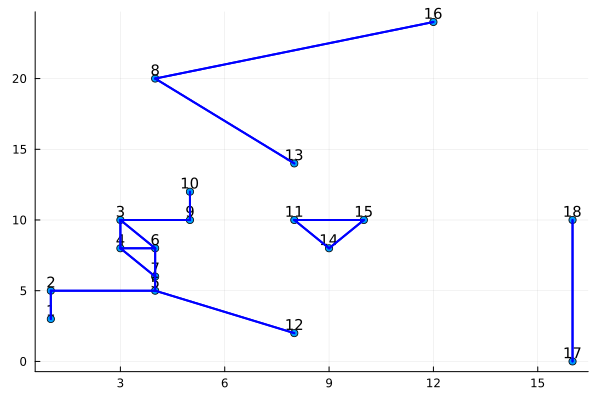

In [83]:
#agregar nueva fila (restricción violada determinada por corte) a PC
@constraint(PC,
[S in compnts], sum([z[u, v] for u ∈ S, v ∈ 1:N if v ∉ S]) ≥ 1)

#optimice nuevamente y dibuje
optimize!(PC)
dibuja(x_pos,y_pos,value.(z))

## Ejercicio 3

En este ejercicio debe automatizar la generación de filas. Para esto

Complete primero la siguiente plantilla

In [ ]:
function resuelvePC(nombre_archivo,flag,maxIter)
    # nombre_archivo: archivo que describe instancia de entrada
    # flag: true o false
    #       si true: Agregar 1 restricción (la asociada al corte que contiene al punto 1)
    #       si false: Agregar 1 restricción por cada componente conexa encontrada. 
    # maxIter: Número máximo de iteraciones a realizar
    
    # recuperar N y puntos del archivo 
    N,x_pos,y_pos,b = lee_archivo(nombre_archivo)
    
    # Crear modelo PC inicial 
    PC = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)) #sin salida esta vez
    
    
    itera=1
    while (itera <= maxIter) 
      ## optimizar, encontrar componentes conexas y agregar 1 o todas dependiendo del valor de flag
      ...
        
      itera=itera+1
    end 
    optimize!(PC)
    dibuja(x_pos,y_pos,value.(z))
end

Ejecute su función en un par de instancias, encontrando los árboles generadores de peso mínimo con restricciones de grados.

In [ ]:
@time resuelvePC("lab1-ejemplo3.txt",true,30)
@time resuelvePC("lab1-ejemplo3.txt",false,30)

In [ ]:
@time resuelvePC("lab1-ejemplo4.txt",true,30)
@time resuelvePC("lab1-ejemplo4.txt",false,30)

## Implementación mediante generación de filas usando lazy-constraints-callbacks.

La técnica anterior permite resolver el problema de árboles generadores de peso mínimo con restricciones de grado para instancias de tamaño moderado resolviendo una serie de PLEs con más y más restricciones. 

Una manera de hacer este proceso más eficiente es realizar una sola ejecución de branch and bound 
y agregar restricciones al modelo no al final del mismo sino cada vez que se encuentra un incumbente.
Los solvers modernos permiten pausar branch and bound en algunos puntos clave, luego llamar a una función externa y finalmente despausar la ejecución (a esto se le llama un callback) y al procedmiento resultante se le llama branch and cut.

En esta sección implementaremos una función callback del tipo lazy-constraint.
Básicamente, una lazy-constraint es una restricción que no se revisa desde el principio de la ejecución sino que solo es agregada al modelo una vez que encontramos un incumbente que no la satisface.

Es posible darle al solver una lista de lazy-constraints desde el principio o generarla vía callbacks.

El modo de implementar una función callback en JuMP+Gurobi (en genérico) es como sigue:
```julia
    #se crea un modelo (para este ejemplo, supongamos que tiene una variable x
    model = Model(... 
    @variable(model, x, ...
    @objective(model, ...
    @constraints(model, ...

    #esta función se llamará cuando Gurobi piensa que tiene una solución entera incumbente
    function mi_callback(cb_data)
        #comando para recuperar valor de la variable x y guardarlo en una variable temporal
        x_val = callback_value(cb_data, x)

        #Nota: la implementación actual de Gurobi podría llamar a esta función cuando la solución es 
        #      fraccional por lo que conviene revisar integralidad.
        
        tolerancia=0.001
        if !(abs(x-round(x))<tolerancia)
          display(string("callback en solución fraccional"))
          return nothing
        end
        
        #sabemos que x es integral
        #buscar restriccion a agregar
        ..
        restriccion_nueva = @build_constraint( .. restriccion ..)
        MOI.submit(model, MOI.LazyConstraint(cb_data), restriccion)
        end
    end

    #mandar función callback al solver.
    MOI.set(model, MOI.LazyConstraintCallback(), mi_callback)

    #si optimizamos, el solver usará la función callback para confirmar factibilidad de sus 
    #soluciones, agregando restricciones si es necesario
```

## Ejercicio 4. 
 
Complete la siguiente plantilla para resolver PC usando callbacks.


In [ ]:
function resuelvePCconCallbacks(nombrearchivo, flag)
    # flag: true o false
    #       si false: suprimir parte de la salida
    
    # recuperar N y puntos del archivo 
    N,x_pos,y_pos,b = lee_archivo(nombrearchivo)
    
   
    # Crear modelo PCcall inicial (sin restricciones de corte)
    PCcall = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)) 
    
    ...
    
    #implementar función callback
        
    function mi_callback(cb_data)
        if flag 
          display(string("Ejecutando callback"))
        end
        
        #Recupera valores de z[i,j] de cb_data
        ...
    
        #Revisar fraccionalidad (retornar si es fraccional).
        #Si flag==true y la solución es fraccional, ejecutar además el siguiente comando:
        #  display(string("callback en solución fraccional"))
        ...
        
        #Encontrar componentes conexas.
        #Si flag==true ejecutar además el siguiente comando:
        #   display(string("Agregando componentes: ", compnts))
        ...

        #Si hay restricciones de corte violadas, agregar 1 o todas dependiendo del valor de flag.
        ...
    end                        
    
    #mandar función callback al solver.
    MOI.set(PCcall, MOI.LazyConstraintCallback(), mi_callback)

    #Optimizar, reportar solución y dibujar.
    optimize!(PCcall)
    dibuja(x_pos, y_pos, value.(PCcall[:z]))
    display(string("Árbol óptimo encontrado, de largo ", objective_value(PCcall)))
    return objective_value(PCcall)
end

Ejecute su función en las instancias que se indican a continuación, encontrando los árboles óptimos (si se topa con problemas de memoria, tiempo, muerte del Kernel, etc., comente los comandos problemáticos y agregue una nota explicando por qué no pudo ejecutarlo).

In [ ]:
@time resuelvePCconCallbacks("lab1-ejemplo4.txt",true)

In [ ]:
@time resuelvePCconCallbacks("lab1-ejemplo5.txt",false)

In [ ]:
@time resuelvePCconCallbacks("lab1-ejemplo6.txt",false)

In [ ]:
@time resuelvePCconCallbacks("lab1-ejemplo7.txt",false)